University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2022  
Luigi Acerbi

# Week 4 exercises

## 1. MCMC convergence diagnostics (4 pts)

The file loaded below contains samples from 3 chains of Metropolis-Hastings sampling for the bimodal target 
$$\pi^*(\theta) = \exp(-\gamma (\theta^2-1)^2)$$
with $\gamma = 4$. Warm-up samples have already been removed from the saved results, so you do not need to remove warm-up samples.

1. Evaluate the $\hat{R}$-statistic defined in Sec. 8.1.1 of the course notes using the original 3 chains. Report your result in Moodle.
2. Evaluate the split-$\hat{R}$ (see Sec. 8.1.1) by splitting the chains in half to obtain 6 chains. Report your result in Moodle.
3. Compute the effective sample size (ESS) for the first chain (1000 samples), when we know the estimates $\mu = 0$, $\sigma^2 = 0.9185$ from an independent long simulation. Use the truncated sum estimate from Sec. 8.1.2 of the course notes. Report your result in Moodle.
   *Hint*:  Use Eqs. 8.1 and 8.4, for which you will have to find the upper bound $K$ of the sum as indicated.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

samples = pd.read_csv('https://www2.helsinki.fi/sites/default/files/atoms/files/bimod_samples.txt', header=None, sep='\t').values

# Part 1

def calcR(chains):
    n = chains.shape[0]
    m = chains.shape[1]
    theta_j = 1/n * np.sum(chains, axis=0)
    theta_dots = 1/m * np.sum(theta_j)
    B = n/(m-1) * np.sum( (theta_j - theta_dots)**2 )
    s_j2 = 1/(n-1) * np.sum( (chains - theta_j)**2, axis=0 )
    W = 1/m * np.sum(s_j2)
    var = (n-1)/n * W + 1/n * B
    return np.sqrt(var/W)

print(calcR(samples))

1.025898298169984


In [2]:
# Part 2

reshaped_samples = np.hstack(np.split(samples, 2))
print(calcR(reshaped_samples))

1.1155720873796102


In [3]:
# Part 3

first_chain = samples[:,0]

def rho(chain, k, i=0):
    index1 = 0
    index2 = k
    mean = 0
    while index2 < len(chain):
        mean += chain[index1] * chain[index2] # mu is 0 so no need to take it into account here
        index1 += 1
        index2 += 1
    mean /= len(chain)
    return mean/0.9185

def findK(chain):
    k = 1
    while ( rho(chain, k) + rho(chain, k+1) >= 0 ):
        k += 2
    return k-2

def calcESS(chain, K):
    M = len(chain)
    ESS = 0
    denom = 0
    for k in range(1, K+1):
        denom += rho(chain, k)
    denom = denom*2 + 1
    return M/denom

K = findK(first_chain)
print(calcESS(first_chain, K))

13.763929528261746


## 2. MCMC sampling for a Bayesian regression model (6 pts)

In this task we will apply MCMC sampling to a linear regression model that predicts the birth weight ('bwt', $y_i$) for old mothers (age >= 30) as a function of the age of the mother, duration of the pregnancy and weight of the mother ('age', 'gestation', 'weight'; $\mathbf{x}_i$).

As our model we will consider a linear regression model fitted to the observations $((\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), \dots, (\mathbf{x}_n, y_n))$. The code below will load the matrix `x` (each row is one sample) and vector `y`. The values $\mathbf{x}_1, \dots, \mathbf{x}_n$ are the *input values* and $y_1, \dots, y_n$ are the *target values*. The loading code normalises all data to have zero mean and unit variance to get the regression coefficients to a shared scale.

We model the data with a linear regression model
$$ y_i = \mathbf{x}_i \boldsymbol{\beta} + \epsilon_i, $$
where $\mathbf{x}_i$ is a row vector of input values, $\boldsymbol{\beta} = (\beta_1, \beta_2, \beta_3)^T$ is a column vector of regression coefficients and $\epsilon_i$ is a Gaussian noise term $\epsilon_i \sim \mathcal{N}(0, \sigma_x^2)$.

The likelihood of the model is
$$ p(Y \mid X, \beta, \sigma_x) = \prod_{i=1}^n \mathcal{N}(y_i; \mathbf{x}_i \boldsymbol{\beta}, \sigma_x^2). $$

The regression coefficients $\beta_j$ have a hierarchical prior
$$ p(\beta_j | \sigma_{\beta}) = \mathcal{N}(\beta_j;\; 0, \sigma_{\beta}^2), \quad j = 1, 2, 3, $$
with standard deviation $\sigma_{\beta}$.
Its prior is
$$ p(\sigma_{\beta}) = \mathrm{Gamma}(k_{\beta} = 2, \theta_{\beta} = 1/2) $$
with shape $k_{\beta}=2$ and scale $\theta_{\beta} = 1/2$.
The prior of the noise standard deviation $\sigma_x$ is
$$ p(\sigma_{x}) = \mathrm{Gamma}(k_{x} = 2, \theta_{x} = 1/2) $$
with shape $k_{x}=2$ and scale $\theta_{x} = 1/2$.
As usual, we assume the prior factorizes as $p(\sigma_\beta, \sigma_x) = p(\sigma_\beta) p(\sigma_x)$.

To ensure the standard deviations are positive, express them as $\sigma_{\beta} = \exp(s_{\beta})$ and $\sigma_x = \exp(s_x)$. Remember to apply the density transformation to transform the priors over $\sigma_{\beta}$ and $\sigma_x$ to those over $s_{\beta}$ and $s_x$!

The full set of model parameters for MCMC is thus $\theta = (s_{\beta}, s_x, \beta_1, \beta_2, \beta_3)$.

Write a Metropolis-Hastings MCMC sampler to sample from the joint posterior distribution of all model parameters $\theta$, $$p(\theta \mid X, Y) = p(s_{\beta}, s_x, \beta_1, \beta_2, \beta_3 \mid X, Y).$$

1. Implement a Metropolis-Hastings MCMC sampler with proposal $q(\theta' ; \theta) = \mathcal{N}(\theta';\; \theta, 0.04^2 \mathbf{I})$, i.e. a multivariate normal proposal centred around the current state with standard deviation 0.04 for each component.
2. Run the sampler for 5000 iterations starting from each of the 4 initial points defined by the columns of `inits`. Discard the first 2500 iterations for each run as warm-up. Compute the split-$\hat{R}$ statistic for the samples of $\theta$. Report the largest split-$\hat{R}$ over different components to Moodle.
3. Check which variable is having convergence issues. Increase the proposal standard deviation for that component to 0.4 while keeping the proposals for the other components the same. Repeat the sampling as above and report the largest split-$\hat{R}$ over different components to Moodle.
4. Report the posterior mean of the log-standard deviation $s_{\beta}$ obtained from combining all the 10000 retained samples from the latter sampler to Moodle.

*Notes*: 
- Please note that all computations and results are based on the unbounded variables $s_{\beta}$ and $s_x$. For the purpose of this exercise, there is no need to transform anything back to the original space of $\sigma_{\beta}$ and $\sigma_x$.
- The [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) has two common representations, one in terms of shape and scale parameters ($k$ and $\theta$) and one in terms of shape and rate parameters ($\alpha$ and $\beta$). Please check that you are using the correct one.

In [4]:
import pandas as pd
import numpy as np
import numpy.random as npr

# Load the data set
babies_full = pd.read_csv("https://www2.helsinki.fi/sites/default/files/atoms/files/babies2.txt", sep='\t')

# Pick a subset
babies = babies_full.loc[(babies_full['age']>=30).values,:]

x = babies[['age', 'gestation', 'weight']].values.astype(float)
y = babies[['bwt']].values.astype(float).squeeze()

# Remove mean from inputs
x -= np.mean(x, 0)
# Standardise input variance
x /= np.std(x, 0)

# Remove mean from outputs
y -= np.mean(y, 0)
# Standardise output variance
y /= np.std(y, 0)

inits = np.array([[ 1.67272789, -0.02134183, -0.78116796, -1.77420787],
                  [-0.6030697,   0.4464263,   0.3627991,  -0.7342916 ],
                  [-1.32685026, -0.37427079, -0.06744599,  0.21175491],
                  [ 0.87702047, -0.54171875, -0.44736686, -2.39045985],
                  [ 1.00631791, -1.34638203, -0.40343913, -0.64535026]])

print(x.shape)
print(y.shape)

(367, 3)
(367,)


In [31]:
def d_mhsample(theta0, n, log_target, drawproposal):
    """
    Metropolis-Hastings sampler for n samples from starting point theta0 in arbitrary dimension.
    log_target is the log of the target pdf, and 
    drawproposal samples from the proposal (assumed symmetric).
    """    
    theta = theta0
    d = len(theta0)
    accepts = 0
    lp = log_target(theta)
    thetas = np.zeros([n, d])
    for i in range(n):
        theta_prop = drawproposal(theta)
        l_prop = log_target(theta_prop)
        if np.log(npr.rand()) < l_prop - lp:
            theta = theta_prop
            lp = l_prop
            accepts += 1
        thetas[i] = theta
    print('Acceptance rate:', accepts/n)
    return thetas

def logPriorS(s):
    return 2*( np.log(2) + s - np.exp(s) )

def lnormpdf(x, mu, sigma):
    """Log pdf of normal density."""
    return -0.5*np.log(2*np.pi) - np.log(sigma) - 0.5*(x-mu)**2/sigma**2

target = lambda theta: np.sum(lnormpdf(y, x @ theta[2:], np.exp(theta[1]) ) ) + logPriorS(theta[0]) + \
            logPriorS(theta[1]) + lnormpdf(theta[2], 0, np.exp(theta[0])) + \
            lnormpdf(theta[3], 0, np.exp(theta[0])) + lnormpdf(theta[4], 0, np.exp(theta[0]))

propose_draws = lambda theta, w: theta + w * npr.randn(*theta.shape)

w = 0.04

# npr.seed(0)

theta = [None]*4

for i in range(4):
    theta[i] = d_mhsample(inits.T[i,:], 5000, target, lambda theta: propose_draws(theta, w))
    theta[i] = theta[i][len(theta[i])//2:]

split_Rs = np.zeros(5)

for i in range(5):
    param_chains = [None]*4
    for j in range(4):
        param_chains[j] = theta[j][:, i]
    param_chains = np.array(param_chains)
    reshaped_samples = np.hstack(np.split(param_chains, 2))
    split_Rs[i] = calcR(reshaped_samples)

print(split_Rs)

Acceptance rate: 0.4184
Acceptance rate: 0.4052
Acceptance rate: 0.398
Acceptance rate: 0.3972
[1.32652883 0.99883607 1.0346852  0.99821745 1.01429116]


In [6]:
target = lambda theta: np.sum(lnormpdf(y, x @ theta[2:], np.exp(theta[1]) ) ) + logPriorS(theta[0]) + \
            logPriorS(theta[1]) + lnormpdf(theta[2], 0, np.exp(theta[0])) + \
            lnormpdf(theta[3], 0, np.exp(theta[0])) + lnormpdf(theta[4], 0, np.exp(theta[0]))

propose_draws = lambda theta, w: theta + w * npr.randn(*theta.shape)

w = np.array( [0.4, 0.04, 0.04, 0.04, 0.04] )

npr.seed(0)

theta = [None]*4

for i in range(4):
    theta[i] = d_mhsample(inits.T[i,:], 5000, target, lambda theta: propose_draws(theta, w))
    theta[i] = theta[i][len(theta[i])//2:]

split_Rs = np.zeros(5)

for i in range(5):
    param_chains = [None]*4
    for j in range(4):
        param_chains[j] = theta[j][:, i]
    param_chains = np.array(param_chains)
    reshaped_samples = np.hstack(np.split(param_chains, 2))
    split_Rs[i] = calcR(reshaped_samples)

print(split_Rs)

Acceptance rate: 0.3466
Acceptance rate: 0.3484
Acceptance rate: 0.3456
Acceptance rate: 0.3582
[1.00655139 1.00620723 1.01110571 0.99279024 0.98396721]


In [7]:
s_beta = []

for i in range(4):
    s_beta.append( theta[i][:,0] )

print(np.mean(np.concatenate(s_beta)))

-0.8205737722874792


## 3. Importance sampling (4 pts)

Develop an importance sampler for the bimodal target
$$\pi(\theta) = \sum_{i=1}^2 p_i \mathcal{N}(\theta ; \mu_i, \sigma_i^2),$$
where $p_1 = p_2 = 1/2$ and $\mu_1 = -1, \mu_2 = 1$.
Use $\mathrm{Laplace}(0, b)$ with a suitable $b$ as the proposal and evaluate the expectation $\mathbb{E}[(\theta-1)^2]$ when
1. $\sigma_1^2 = \sigma_2^2 = 0.5$.
2. $\sigma_1^2 = \sigma_2^2 = 0.1$.

The required tolerance for the answer is $\pm 0.1$.

In order to estimate the accuracy of your answer, it is recommended to run the sampler a few times and compute the standard deviation of the values you obtain. Monte Carlo error scales as $1/\sqrt{n}$ with the number of iterations $n$.

In [8]:
from scipy.stats import norm, laplace

# f(x) = pi(x), g(x) = laplace(x)

def target(theta, sigma_sq):
    return 0.5*norm.pdf(theta, -1, np.sqrt(sigma_sq)) + 0.5*norm.pdf(theta, 1, np.sqrt(sigma_sq))

def sample(iters, b, sigma_sq):

    theta = npr.laplace(0, b, iters)

    return np.mean((theta - 1)**2 * target(theta, sigma_sq) / laplace.pdf(theta, 0, b))

# part 1
expectations = np.zeros(100)
npr.seed(0)
for i in range(100):
    expectations[i] = sample(10000, 1.5, 0.5)
    
print(f'Average expectation is {expectations.mean()} with SD {expectations.std()}')

Average expectation is 2.4974261535474933 with SD 0.03387243727127632


In [9]:
expectations = np.zeros(10)
npr.seed(0)
for i in range(10):
    expectations[i] = sample(100000, 1, 0.1)
    
print(f'Average expectation is {expectations.mean()} with SD {expectations.std()}')

Average expectation is 2.095833306652417 with SD 0.016375714444056413


## 4. Rejection ABC for a dynamical model (6 pts)

In this task we will develop an ABC sampler for the autoregressive (AR) model:
$$ x_{t+1} = a x_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2). $$
Throughout the exercise, we assume $x_0 = 1$. The model has two parameters, $a$ and $\sigma$. We set priors
$$ p(a) = \mathrm{Uniform}(a;\; 0, 1), \quad p(\sigma) = \mathrm{Gamma}(\sigma;\; k_\sigma, \theta_\sigma) $$
with $k_\sigma = 8, \theta_\sigma = 1/8$. Note that we use the shape/scale parametrisation also used by NumPy and that the prior is over $\sigma$, not $\sigma^2$ (also more consistent with NumPy parametrisation).

1. Implement a function to simulate the AR process. Test your function by generating and plotting two independent realisations of length 200 with $a = 0.75$, $\sigma = 0.2$. Notice how the sequences diverge relatively quickly and are essentially independent toward the end. *Hint*: Length 200 means that the generated sequence will take values $x_0, x_1, \ldots, x_{199}$.
2. Sample 5000 sequences from the AR process of length 200 with $a = 0.75$, $\sigma = 0.2$. For each sequence, extract the last value. Compute the standard deviation of the last values across the 5000 simulated sequences and report it in Moodle.
3. For the purpose of ABC sampling, we are going to summarize the sequences with the 2-dimensional summary statistics
$$ S(X) = \left( \frac{1}{N} \sum_{i=0}^{N-1} x_i^2, \frac{1}{N-1} \sum_{i=0}^{N-2} x_i x_{i+1} \right). $$
Load the the single observed sequence $X$ (the data) with the code below and evaluate $S(X)$ on the provided sequence. Report the two summary statistics of the data in Moodle.
4. Implement an ABC sampler to infer the posterior over $a$ and $\sigma$ given the single observed sequence $X$ loaded below using the simulator implemented above and the 2-dimensional summary statistics defined above. Run your sampler to generate samples with acceptance threshold $\| S(X) - S(X^\star)\|_2 \le \epsilon$ with $\epsilon = 0.2$.
5. Report the approximate posterior means and standard deviations of $a$ and $\sigma$ to Moodle.

The required tolerance on the posterior means and standard deviations is $\pm 0.03$.

*Hints*:
- Note that for the acceptance threshold we are using the standard Euclidean metric: $\|v\|_2 = \sqrt{\sum_{i} v_i^2}$.
- The ABC sampler here can easily require tens of seconds or more when the number of samples is large, so you should be careful when increasing the number of samples. A reasonably good implementation should be able to reach the required accuracy in less than a minute.

In [10]:
import pandas as pd

dataframe = pd.read_csv('https://www2.helsinki.fi/sites/default/files/atoms/files/ar_time_series_data.txt', header=None, sep='\t')
data = dataframe.values[:,0]

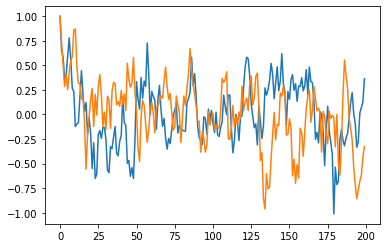

In [11]:
import matplotlib.pyplot as plt

# Part 1

def generateRealisation(a, sigma, n=200):
    x = np.zeros(n)
    x[0] = 1
    for i in range(1, n):
        x[i] = a*x[i-1] + npr.normal(0, sigma)
    return x

realisation1 = generateRealisation(0.75, 0.2)
realisation2 = generateRealisation(0.75, 0.2)

plt.plot(realisation1)
plt.plot(realisation2)
plt.show()

In [12]:
# Part 2

npr.seed(0)
part2sd = np.std( [generateRealisation(0.75, 0.2)[199] for _ in range(5000)] )
print(part2sd)

0.3091100436463519


In [13]:
# Part 3

def generateSummary(x):
    N = len(x)
    stat1 = 1/N * np.sum( x**2 )
    stat2 = 1/(N-1) * np.sum( np.array([i*j for i, j in zip(x, x[1:])]) )
    return np.array([stat1, stat2])

print(f'Summary statistics: {generateSummary(data)}')

Summary statistics: [1.30559239 1.18492572]


In [14]:
# Part 4

def abc(x, N, epsilon = 0.2, Ndata=len(data)):
    samples = np.zeros((N, 2))
    nsamples = 0
    orig_summary = generateSummary(x)
    while nsamples < N:
        a = npr.uniform(0, 1)
        sigma = npr.gamma(8, 1/8)
        mydata = generateRealisation(a, sigma, Ndata)
        myerr = np.sqrt(np.sum((orig_summary - generateSummary(mydata))**2))
        if myerr <= epsilon:
            samples[nsamples,0] = a
            samples[nsamples,1] = sigma
            nsamples += 1
    return samples

npr.seed(0)
samples = abc(data, 1000)

print(f'For a, we have mean={np.mean(samples[:, 0])} and SD={np.std(samples[:, 0])}' )
print(f'For sigma, we have mean={np.mean(samples[:, 1])} and SD={np.std(samples[:, 1])}' )

For a, we have mean=0.8162378107951243 and SD=0.06887973488075542
For sigma, we have mean=0.6793969825391248 and SD=0.11170365675187066
